In [1]:
#!pip install widgetsnbextension
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!pip install nbopen
#!pip install import_ipynb
#!pip install python-dotenv
#!pip install pandas
#!pip install psycopg2
#!pip install ipynb
#!pip install plotly
#!pip install nltk
#!pip install scikit-learn
#!pip install matplotlib
#!pip install seaborn
#!pip install jupysec
#!pip install wordcloud

In [2]:
import logging
# Configure logging to write messages with INFO level or higher to a file named "app.log" with a timestamp and message format
logging.basicConfig(filename='app.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
import re
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import textwrap
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import zipfile as zf
from zipfile import ZipFile
from jupysec.rules import Rules
from wordcloud import WordCloud

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\exocu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\exocu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\exocu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\exocu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import psycopg2
from psycopg2 import connect
from dotenv import load_dotenv
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display as ipydisplay, clear_output, Image, Javascript, HTML, IFrame 
import import_ipynb
import nbopen
import base64
import string
import time
#import webbrowser

In [4]:
display(HTML("<style>.container {width:90% !important; }</style>"))

In [5]:
#The client, Hideous Mummy Comics, wants to be able to offer comic book recommendations based on a customer's previous purchases. The initial proof of concept of this recommendation system uses the Marvel Comic Books Dataset, found here: https://www.kaggle.com/datasets/deepcontractor/marvel-comic-books. 

In [6]:
#The dataset was saved to a PostgreSQL database table, "marvelcomics". A new sequential column called "comic_id" was appended to "marvelcomics", and "customer" and "purchase" tables were added to the database in order to perform dataframe queries involving multiple tables, customer_ids, comic_ids, purchase_ids, purchase_dates, etc. All rows containing null or nan values in the marvelcomics columns "issue_title", "publish_date", "issue_description", "penciler", "writer", and "comic_id" were deleted from the database in pgAdmin 4; deletion of null/nan values in other columns may be required in the future, dependent upon user requirements. 

In [7]:
# Get security findings
#Rules().get_findings() # Commented out for Appmode

In [8]:
# Connect to database
load_dotenv('.env') # take environment variables from .env

db_name = os.getenv("DB_NAME")
user_name = os.getenv("DB_USERNAME")
host_name = os.getenv("DB_PATH")
passwd = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

conn = psycopg2.connect(host=host_name, dbname=db_name, user=user_name, password=passwd, port=db_port)

cursor = conn.cursor()
logging.info("Connected to database.")

customer_table_query = pd.read_sql_query("SELECT cust_id, cust_name, username, user_pass FROM customer", conn)

marvel_comics_table_query = pd.read_sql_query("SELECT comic_name, issue_title, publish_date, issue_description, penciler, writer, comic_id FROM marvelcomics", conn)

marvel_comics_query_2 = pd.read_sql_query("SELECT issue_title, publish_date, issue_description, penciler, writer, comic_id FROM marvelcomics", conn) 

marvel_comics_query_3 = pd.read_sql_query("SELECT comic_name, issue_title, publish_date, penciler, writer, comic_id FROM marvelcomics", conn)

purchase_table_query = pd.read_sql_query("SELECT purchase_date, cust_id, comic_id FROM purchase", conn)

In [9]:
#Database tables were then saved to pandas dataframes, using only the necessary columns for each dataframe. Copies of some dataframes are used to preserve the data in the original dataframes for possible future use.

In [10]:
# Customers DataFrame = df
df = pd.DataFrame(customer_table_query, columns=['cust_id', 'cust_name', 'username', 'user_pass'])
df.to_csv('customers.csv', index=False)
df = pd.read_csv('customers.csv')

In [11]:
# Marvel Comics DataFrame = df1
df1 = pd.DataFrame(marvel_comics_table_query, columns=['comic_name', 'issue_title', 'publish_date', 'issue_description', 'penciler', 'writer', 'comic_id'])
df1.fillna("", inplace=True)
df1.to_csv('marvel_comics.csv', index=False)
df1 = pd.read_csv('marvel_comics.csv')

In [12]:
# Purchases DataFrame = df2
df2 = pd.DataFrame(purchase_table_query, columns=['purchase_date', 'cust_id', 'comic_id'])
df2.to_csv('purchases.csv', index=False)
df2 = pd.read_csv('purchases.csv')
#df2

In [13]:
cust_df = df.copy() # Copy of original customers dataframe

comics_df = pd.DataFrame(marvel_comics_query_3, columns=['comic_name', 'issue_title', 'publish_date', 'penciler', 'writer', 'comic_id'])
comics_df.to_csv('comics.csv', index=False)
comics_df = pd.read_csv('comics.csv')

purch_df = df2.copy() # Copy of original purchases dataframe

In [14]:
#To test that the recommendation system performs adequately, a mock login page was created. This login page takes a username and password and, upon successful login, displays comic recommendations based on the descriptions associated with the customer's last 3 comic book purchases. There are also buttons displayed to view reports (a bar chart visualizing the customer's preferred titles based on most purchased titles and a list of the titles/number of issues of each title the customer has purchased), a network graph (a visualization of the cosine similarities of all titles in the marvelcomics dataframe), and an exit button.

In [15]:
# Widgets
customer_name_input = widgets.Text(placeholder = 'Enter username') # prompt for customer to enter their username

customer_password_input = widgets.Password(placeholder = 'Enter password') # prompt for customer to enter their password

login_button = widgets.Button(description='Login', disabled=False, tooltip='Login', width='auto') # login button

login_button.style.button_color = 'MediumAquamarine' # login button color

In [16]:
# Layout for recommendations output
output_box_1 = widgets.Output()

reports_button = widgets.Button(description='Get Reports', disabled=False)

exit_button = widgets.Button(description='Exit', disabled=False)
exit_button.style.button_color = 'red'

recommendations_page = widgets.HBox([output_box_1, reports_button, exit_button])


In [17]:
# Image
image_path = 'C:/Users/exocu/Downloads/HideousMummy.jpg'

with open(image_path, "rb") as f:
    image_data = base64.b64encode(f.read()).decode()

img_tag = f"<img src='data:image/jpeg;base64, {image_data}'>"

image_html = HTML(img_tag)

image_widget = widgets.Output()

with image_widget:
     display(image_html)


In [18]:
# Layout for login
vbox_result = widgets.VBox([customer_name_input, customer_password_input, login_button])
text_0 = widgets.HTML(value="<h1>Hideous Mummy Comics</h1>")
label_headline = widgets.Label(value='', style={'description_width':'initial'}, align_content='center')
vbox_headline = widgets.VBox([label_headline])

vbox_text = widgets.VBox([text_0, vbox_result])
page = widgets.VBox([vbox_headline, vbox_text, image_widget])

out = widgets.Output()

In [19]:
# Get customer id from .txt file
with open('customer_id.txt', 'r') as file:
    c_id = int(file.readline().strip().replace("'", "")) # Change value to int

# Compare c_id to cust_id in purchase table to retrieve customer's last 3 purchases
df3 = df2[df2['cust_id'] == c_id].sort_values(by='purchase_date', ascending=False)
df3.to_csv('df3.csv', index=False)
df3 = pd.read_csv('df3.csv')

df_last_3 = df3.head(3) 

In [20]:
# Get data from marvelcomics table that matches each comic_id to use for recommendations
merged_df = pd.merge(df_last_3, df1[['comic_id', 'issue_title', 'issue_description']], on='comic_id', how='left')


In [21]:
# Add descriptions from merged_df to a list for use with recommendation function
last_3_purchase_descrips = merged_df['issue_title'].to_list()

In [22]:
# Marvel Comics DataFrame #2 (copy) = df4_copied
df4 = pd.DataFrame(marvel_comics_table_query, columns=['issue_title', 'publish_date', 'issue_description', 'penciler', 'writer', 'comic_id'])
df4.to_csv('df4.csv', index=False)
df4 = pd.read_csv('df4.csv', na_values=['null', 'na', 'NA', 'nan', 'NaN'])
df4.dropna(inplace=True)

df4_copied = df4.copy()
#df4_copied['issue_title']

In [23]:
#df4_copied.isnull().sum()

In [24]:
# Close database connection and cursor
cursor.close()
conn.close()

In [25]:
# Initialize the lemmatizer
lemmy = WordNetLemmatizer()

# Initilaize the stopwords
stop_words = set(stopwords.words('english'))

In [26]:
# Function to preprocess issue_description text
def preprocess_description(text):
    text = str(text) # Convert input text to string

    text = text.lower() # Convert text to lowercase

    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove special characters and digits

    tokens = nltk.word_tokenize(text) # Divide sentences into terms (tokens)

    tokens = [word for word in tokens if word not in stop_words] # Remove the stop words

    tokens = [lemmy.lemmatize(word) for word in tokens] # Lemmatize the tokens

    return " ".join(tokens) # Return processed text as a string


In [27]:
# Function to preprocess dataframe
def preprocess_dataframe(df, column_name):
    df[column_name] = df[column_name].apply(preprocess_description)
    return df

In [28]:
df4_copied = preprocess_dataframe(df4_copied, 'issue_description')
#df4_copied['issue_description'].head(-20)

In [29]:
tfidf = TfidfVectorizer(min_df=5, max_df=0.5, stop_words='english') 
tfidf_matrix = tfidf.fit_transform(df4_copied['issue_description']) # Develop vector matrix for issue_descriptions using fit_transform

In [30]:
#tfidf_matrix.todense()

In [31]:
#tfidf_matrix.shape

In [32]:
# Define simlarity threshold
min_similarity_threshold = 0.25

In [33]:
# Function to batch process the tfidf_matrix using cosine similarity to help with memory usage
def batch_cosine_similarity(tfidf_matrix, min_similarity_threshold = 0.25, batch_size=1000):
    n_rows = tfidf_matrix.shape[0]
    cosine_sim = np.zeros((n_rows, n_rows))

    for start in range(0, n_rows, batch_size):
        end = min(start + batch_size, n_rows)
        batch_sim = linear_kernel(tfidf_matrix[start:end], tfidf_matrix)
        cosine_sim[start:end] = batch_sim
        
        # Apply thresholding to remove values below min_similarity_threshold
        cosine_sim[cosine_sim < min_similarity_threshold] = 0.0
    
    return cosine_sim

cosine_sim = batch_cosine_similarity(tfidf_matrix, min_similarity_threshold=min_similarity_threshold)

In [34]:
indices = pd.Series(df4_copied.index, index=df4_copied['issue_title']).drop_duplicates()
#indices[:-20]

In [35]:
# Function to take issue_title as input and then output top 3 recommendations 
# (comics most similar to issue_description mapped to input issue_title)
title = df4_copied['issue_title']

def get_recommendations(title, cosine_sim=cosine_sim, top_n=3):
    if title in indices:
        idx = indices[title]
        #print("Index for title:", idx) # Comment out
        #print("Cosine similarities for title:", cosine_sim[idx]) 
        sim_scores = list(enumerate(cosine_sim[idx]))
        #print("Enumerated similarity scores:", sim_scores) 
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        #print("Sorted similarity scores:", sim_scores) 
        sim_scores = sim_scores[1:top_n + 1]

        print("Based on your purchase of "+title+", you should check out these comics:\n")
        print("\n")
        for i, score in sim_scores:
            description = str(df1['issue_description'].iloc[i])
            wrapped_description = textwrap.fill(description, width=50)
            formatted_score = '{:.2%}'.format(score) # Format score to read like '45.00%'
            print(f"Title: {df1['issue_title'].iloc[i]}\n\nWriter: {df1['writer'].iloc[i]}\n\nPenciler: {df1['penciler'].iloc[i]}\n\nDescription: {wrapped_description}\n\nSimilarity Score: {formatted_score}\n")
            print("\n\n")
    else:
        logging.error("Title not found in index.")
        print("Title not found in the index.")



In [36]:
# Test run; Insert any issue from the dataframe into the parentheses as shown
#get_recommendations('A Year of Marvels: April Infinite Comic (2016) #1')

In [37]:
# Define login logic
def login(self):      
    
    try:

        login_button.description = 'Attempting Login...'

        # Query dataframe to check if user exists/password is correct
        # 1) Get input username and password
        customer_user_name = customer_name_input.value
        customer_password = customer_password_input.value
        
        # 2) Check inputs against values in dataframe, then grab customer id and name
        for index, row in df.iterrows():
            if row['username'] == customer_user_name and row['user_pass'] == customer_password:

                customer_id = df.loc[df['username'] == customer_user_name, 'cust_id'].iloc[0] # Extract customer id from df result
                customer_name = df.loc[df['user_pass'] == customer_password, 'cust_name'].iloc[0] # Extract customer name from df result

                login_result = f'Welcome, {customer_name}.'
                login_button.layout.width = 'auto'
                login_button.description = login_result


                if customer_id:

                    with open("customer_id.txt", "w") as f:
                        f.write(str(customer_id)) # Save customer id as string to .txt file

                    # Get customer id from .txt file
                    with open('customer_id.txt', 'r') as file:
                        c_id = int(file.readline().strip().replace("'", "")) # Change value to int

                    logging.info("Succesful login, Customer ID: " + str(c_id))

                    # Compare c_id to cust_id in purchase table to retrieve customer's last 3 purchases
                    df3 = df2[df2['cust_id'] == c_id].sort_values(by='purchase_date', ascending=False)

                    df_last_3 = df3.head(3)
     
                    # Get data from marvelcomics table that matches each comic_id to use for recommendations
                    merged_df = pd.merge(df_last_3, df1[['comic_id', 'issue_title', 'issue_description']], on='comic_id', how='left')

                    # Add descriptions from merged_df to a list for use with recommendation function
                    last_3_purchase_descrips = merged_df['issue_title'].to_list()  

                    output_box_1.clear_output()

                    with output_box_1:
                        for title in last_3_purchase_descrips:
                            get_recommendations(title)
                                       
                    display(recommendations_page)
                    
                else:
                    logging.error("Invalid username or password or both.")
                    login_result = 'Invalid username or password. Boo! Hiss!'
                    login_button.description = login_result
                    login_status = False
            
    except Exception as e:
        logging.exception(f"An error has occurred: {str(e)}")
        print(f"An error has occurred: {str(e)}")

# Bind login logic to button click)
logging.info("login_button clicked")
login_button.on_click(login)

In [38]:
# Visualized data...

# Get customer's top 10 favorite (preferred) titles by purchase

# Merge dataframes
merged_df2 = pd.merge(cust_df, purch_df, on='cust_id')
merged_df2 = pd.merge(merged_df2, comics_df, on='comic_id')

# Function to handle cases where only single issues of all comic_names purchased by customer are found
def get_top_comics(c_id):
    customer_data = merged_df2[merged_df2['cust_id'] == c_id]

    if customer_data.empty:
        logging.error("customer_data.empty")
        return None
    else:
        # Calculate the number of purchases per comic (comic_name) for customer with cust_id
        top_comics = customer_data.groupby('comic_name').size().reset_index(name='purchase_count')
        #print(top_comics)
        top_comics = top_comics.sort_values(by='purchase_count', ascending=False) # Sort by purchase count
        
        logging.info("customer's top_comics values successfully listed")
        return top_comics.values.tolist()


In [39]:
# Function to display bar chart detailing logged-in customer's top 10 preferred 
# comic titles according to purchase history
def display_top_comics_chart(c_id):
    
    customer_data = merged_df2[merged_df2['cust_id'] == c_id]

    if customer_data.empty:
        logging.error("customer has no purchases")
        print("No purchases for this customer.")
    else:
        purchase_counts = customer_data['comic_name'].value_counts().reset_index()
        purchase_counts.columns = ['comic_name', 'purchase_count']

        top_comics_chart = purchase_counts.sort_values(by='purchase_count', ascending=False).head(10)
        logging.info("Creating bar chart detailing customer's top comics...")
    
        plt.figure(figsize=(10, 6))
        plt.barh(top_comics_chart['comic_name'], top_comics_chart['purchase_count'], color='skyblue')
        plt.xlabel('Number of Issues Purchased per Title')
        plt.ylabel('Comic Name')
        plt.title("Customer's Preferred Comic Book Titles")
        plt.gca().invert_yaxis() # Invert y-axis to show title with most purchases at top
        plt.xticks(np.arange(0, top_comics_chart['purchase_count'].max() + 1, 1)) # Ensure only whole purchase values are shown along x-axis 
        plt.show()

        

In [40]:
# Define reports button logic

def reports(self):

    # Get customer id from .txt file
    with open('customer_id.txt', 'r') as file:
        c_id = int(file.readline().strip().replace("'", "")) # Change value to int
    # Get customer id from .txt file
        display_top_comics_chart(c_id)
    #get_customer_top_titles() # Titles purchased recently by customers (10 listed titles is default, but will be less if fewer than 10 purchases exist for customer)
    top_comics = get_top_comics(c_id)
    if top_comics:
        logging.info("Printing customer's purchased titles...")
        print("Customer's Purchased Titles")
        for comic in top_comics:
            print(comic)

reports_button.on_click(reports)
logging.info("reports_button clicked")

In [41]:
# Display network graph showing cosine similarities of all comic book titles in the dataframe
def get_network_graph():   
    
    zip_file_path = 'C:/Users/exocu/Comic_Recommender/network_graph.zip'
    
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('extracted_files')
        
    html_file_path = 'extracted_files/network_graph.html'
    
    # Display the HTML content in the notebook
    display(IFrame(html_file_path, width=1000, height=600))
    #display(FileLink(html_file_path))
    
    
    # For opening/displaying the network graph in a new webrowser window
    
    # Path to the Firefox executable
    #firefox_path = "C:/Program Files/Mozilla Firefox/firefox.exe"

    # Check if Firefox executable exists
    #if os.path.exists(firefox_path):
        # Specify Firefox as the browser to open the HTML file
        #webbrowser.register('firefox', None, webbrowser.BackgroundBrowser(firefox_path))
        #webbrowser.get('firefox').open(html_file_path)
    
    #else:
        # Interactive network graph visualizing the proximity of cosine similarities of all titles in the dataset
        #logging.info("Opening cosine similarities network graph...")
        #webbrowser.open(html_file_path)

In [42]:
#The client specifically addressed the issue of offloading comic book backstock. The less popular titles and issues continue to take up physical space in the shop, and the recommendation system needs to allow for comics with less similar descriptions to be recommended. 

#However, a way to recommend comics by similar titles (for use by customers, but more specifically for Hideous Mummy's in-store recommendations) is also available to the client, with greater similarity between input titles and recommendations. There are 2 ways to search for a title: using dropdown menus or a search box. 

#The dropdown menus produce more accurate recommendations faster, given that the entire selected title is submitted and compared to the titles in the dataframe, as opposed to the search box's input being compared as it is typed, incomplete until the user stops typing. There is also a distinct lag between the finalized recommendations given when using the search box, due to the call to the recommendations_by_search function for each character typed into the search box.

In [43]:
# Recommendations by title, using 2 dropdowns and output, as well as a search box and output

# As implemented, the search box is a less reliable method of getting recommendations,
# due to exact title matches being wholly dependent upon user input.

recommendations = []

def cosine_similarity(x, y):
    return linear_kernel(x, y)

# Dropdown to select comic_name for recommendations by comic_name
comic_selecter_dropdown = widgets.Dropdown(options=list(comics_df['comic_name'].unique()), description='Comic Title', disabled=False)
comic_selecter_dropdown.layout.width = '480px'

# Function to filter comic names based on the selected letter
def filter_comic_names(letter):
    filtered_comics = comics_df[comics_df['comic_name'].str.startswith(letter)]
    comic_selecter_dropdown.options = list(filtered_comics['comic_name'].unique())

# Create dropdown for selecting the first letter of comic names
title_begins_with_dropdown = widgets.Dropdown(options=[chr(i) for i in range(65, 91)], description='Starts With')
title_begins_with_dropdown.layout.width = '480px'

# Function to handle changes in title_begins_with_dropdown
def handle_letter_change(change):
    if change.new is not None:
        filter_comic_names(change.new)
    else:
        pass

title_begins_with_dropdown.observe(handle_letter_change, names='value')

def handle_dropdown_change(comic_title):
    print(f"Selected Comic Title: {comic_title}")

filter_comic_names('A')

# Modify TF-IDF and Cosine Similarity to use comic_name rather than issue_description
tfidf_vectorizer2 = TfidfVectorizer(min_df=5, max_df=0.5, stop_words='english')
tfidf_matrix = tfidf_vectorizer2.fit_transform(comics_df['comic_name'])

# Define similarity threshold
min_similarity_threshold = 0.05

# Function to get recommendations by comic_name (The comic book's title)
def get_title_recs(comic_title, tfidf_matrix=tfidf_matrix, min_similarity=min_similarity_threshold):

    comic_tfidf = tfidf_vectorizer2.transform([comic_title])
    
    cosine_similarities = cosine_similarity(comic_tfidf, tfidf_matrix).flatten()
    
    # Filter out similarities below minimum threshold
    similar_indices = [i for i, score in enumerate(cosine_similarities) if score >= min_similarity]
    
    recommended_titles = comics_df.iloc[similar_indices]['comic_name'].tolist()

    return recommended_titles

output_title_recommendations = widgets.Output()

# Function to ensure unique recommendations and eliminate the selected comic as a recommended comic
def get_unique_recs(selected_comic, num_recommendations):
    # Get index of selected comic
    selected_index = comics_df[comics_df['comic_name'] == selected_comic].index[0]

    # Calculate cosine similarity scores
    cosine_similarity_scores = cosine_similarity(tfidf_matrix[selected_index:selected_index+1], tfidf_matrix).flatten()

    # Sort indices based on similarity scores
    sim_scores_sorted_indices = cosine_similarity_scores.argsort()[::-1]

    # Initialize a list to store unique recommendations
    unique_recs = []
        
    # Iterate over sorted indices
    for index in sim_scores_sorted_indices:
        comic_name = comics_df.iloc[index]['comic_name']
            
        # Skip the selected comic and any duplicate recommendations
        if comic_name != selected_comic and comic_name not in unique_recs:
            unique_recs.append(comic_name)

        # Break if desired number of recommendations is reached    
        if len(unique_recs) >= num_recommendations:
            break

    return unique_recs

# Function to update output widget with recommended titles
def update_title_recs(change):
    global recommendations
    selected_comic = change.new
    if selected_comic:    
        recommendations = get_unique_recs(selected_comic, 5)

        with output_title_recommendations:
            output_title_recommendations.clear_output()
            logging.info("Printing recommendations (via dropdowns)...")
            print("Based on your selection, you should check out these titles:")
            print()
            for comic in recommendations[:5]:
                print(comic)

comic_selecter_dropdown.observe(update_title_recs, names='value')

# Function to clear selections in both dropdowns
def clear_dropdown_selections():
    comic_selecter_dropdown.value = None
    title_begins_with_dropdown.value = None

# Get recommendation using search function
search_box = widgets.Text(description='Search', disabled=False)
search_box.layout.width='480px'

# Function to get recommendations by comparing string input to titles in dataframe
def recommendations_by_search(change):
    search_query = change.new
    if search_query is not None:
        clear_dropdown_selections()
        filtered_comics_df = comics_df[comics_df['comic_name'].str.contains(search_query, case=False)]      

        unique_recommendations = set()
        if not filtered_comics_df.empty:
            # Pre-compute TF-IDF vectors for all comic names
            comic_tfidf_matrix = tfidf_vectorizer2.transform(filtered_comics_df['comic_name'])
            
            for comic_tfidf in comic_tfidf_matrix:
                # Calculate cosine similarities with all TF-IDF vectors
                cosine_similarities = cosine_similarity(comic_tfidf, tfidf_matrix).flatten()
                similar_indices = cosine_similarities.argsort()[:-6:-1]
                recommended_titles = comics_df.iloc[similar_indices]['comic_name'].tolist()
                unique_recommendations.update(recommended_titles[:5])

        with output_title_recommendations:
            output_title_recommendations.clear_output()
            logging.info("Printing recommendations (via search_box)...")
            print("Based on your search, you should check out these titles:")
            print()
            for title in list(unique_recommendations)[:5]:
                print(title)
    
    else:
        with output_title_recommendations:
            output_title_recommendations.clear_output()
            print("Search for a title to get recommendations.")            

search_box.observe(recommendations_by_search, names='value')

# Function to update selected_comic_title
def update_selected_comic_title(change):
    global selected_comic_title
    selected_comic_title = change.new
    search_box.value = '' # Clear search_box when dropdown is used

# Observe changes in comic_selecter_dropdown and search_box
comic_selecter_dropdown.observe(update_selected_comic_title, names='value')
search_box.observe(update_selected_comic_title, names='value')

# Function to handle title_begins_with dropdown
def secondary_letter_change_handler(change):
    if change.new is not None:
        filter_comic_names(change.new)
        search_box.value = '' # Clear search_box when begins_with_dropdown is used
    else:
        pass

title_begins_with_dropdown.observe(secondary_letter_change_handler, names='value')

rec_similarities_scatterplot_button = widgets.Button(description='Recommendation Similarities Scatterplot', disabled=False)
rec_similarities_scatterplot_button.layout.width = 'auto'

#VBox for dropdowns
dropdowns_box = widgets.VBox([title_begins_with_dropdown])

# VBox for search_box and search_box's ouput widget
search_v_box = widgets.VBox([search_box, output_title_recommendations])

# HBox to hold dropdowns, search_box, and search_box's output widget
inputs_box = widgets.HBox([dropdowns_box, search_v_box])


In [44]:
#An interactive scatterplot is created and opened in a new browser window when a button is clicked, and displays points for the selected title and its group of recommendations. Hovering over a plotted point will display the comic's title and the cosine similarity score of that title in relation to the title selected.

In [45]:
# Global variable to set selected comic title
selected_comic_title = None

# Function to create scatterplot
def create_scatterplot():
    
    global selected_comic_title, recommendations    
    
    # Check if selected_comic_title is set
    if selected_comic_title is not None:
        logging.info("Creating scatterplot...")
        # Calculate cosine similarities for selected comic title
        comic_tfidf = tfidf_vectorizer2.transform([selected_comic_title])
        cosine_similarities = cosine_similarity(comic_tfidf, tfidf_matrix).flatten()

        # Get indices of top most similar comics
        top_indices = cosine_similarities.argsort()[:-101:-1]
        if len(top_indices) < 100:
            top_indices = cosine_similarities.argsort()[:-len(top_indices)-1:-1]

        # Get titles and similarities of top most similar comics
        similar_comics = comics_df.iloc[top_indices]
        similar_titles = similar_comics['comic_name']
        similarities = cosine_similarities[top_indices]

        # Ensure inclusion of recommended comics with selected comic
        recommended_indices = [comics_df[comics_df['comic_name'] == comic].index[0] for comic in recommendations]
        similar_comics_recs = comics_df.iloc[recommended_indices]
        similar_titles_recs = similar_comics_recs['comic_name']
        similarities_recs = [1.0] * len(recommendations) # Similarity set to 1 for recommended comics

        # Combine titles and similarities for scatterplot
        combined_titles = pd.concat([similar_titles, similar_titles_recs], ignore_index=True)
        combined_similarities = np.concatenate([similarities, similarities_recs])
        
        # Hover text with titles and cosine similarity scores
        hover_text = [f'{title}: {sim:.2f}' for title, sim in zip(combined_titles, combined_similarities)]
        

        # Create scatterplot data
        scatter_data = go.Scatter(
            x=combined_titles,
            y=combined_similarities,
            mode='markers',
            marker=dict(
                size=10,
                color=combined_similarities,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(
                    title='Cosine Similarity<br>&nbsp;',
                    titleside='right'
                ),
            ),
            text=hover_text,
            hoverinfo='text'
         )
        
        # Create lines to connect plot points
        line_data = []
        for i in range(len(similar_titles)):
            line_data.append(go.Scatter(
            x=[selected_comic_title, similar_titles.iloc[i]],
            y=[1.0, similarities[i]],
            mode='lines',
            hoverinfo='text',
            line=dict(
                color='gray',
                width=1
            ),
            showlegend=False
            ))

        # Create layout for scatterplot
        layout = go.Layout(
            title=f"Top Similar Comics for {selected_comic_title}",
            xaxis=dict(title="Comic Title"),
            yaxis=dict(title="Cosine Similarity"),
            width=1600,
            height=800
        )

        # Create figure and plot scatterplot
        fig = go.Figure(data=[scatter_data, *line_data], layout=layout)
        
        # Clear any previously generated scatterplots
        fig.data = []
        
        fig.add_trace(scatter_data)
        for line in line_data:
            fig.add_trace(line)
        
        fig.update_layout(yaxis={'categoryorder':'total ascending'})
        fig.show()
    else:
        print("Select a comic title.")

# Function to update selected comic title
def update_selected_comic_title(change):
    global selected_comic_title
    selected_comic_title =  change.new

# Observe changes in comic_selecter_dropdown and search_box
comic_selecter_dropdown.observe(update_selected_comic_title, names='value')
search_box.observe(update_selected_comic_title, names='value')

# Bind to button
rec_similarities_scatterplot_button.on_click(lambda _:create_scatterplot())
logging.info("rec_similarities_scatterplot_button clicked")


In [46]:
# Create network graph visualizing cosine similarities of all titles in the dataframe
# Commented out because it takes a long time to run and doesn't need to be run more than once.

#df5 = comics_df.copy()
#df5 = preprocess_dataframe(df5, 'comic_name')

#tfidf_vectorizer = TfidfVectorizer(stop_words='english')
#tfidf_matrix = tfidf_vectorizer.fit_transform(df5['comic_name'])
#cosine_similarity_matrix = batch_cosine_similarity(tfidf_matrix)

# Create the network graph
#def create_network_graph():
    # Define labels and edges for the graph
    #labels = list(df5['comic_name'])
    #edge_x = []
    #edge_y = []
    #weights = []

    # Create graph edges
    #for i in range(len(comics_df)):
        #for j in range(i+1, len(df5)):
            #if cosine_similarity_matrix[i, j] > 0.5:  # Adjust threshold as needed
                #edge_x.append(labels[i])
                #edge_y.append(labels[j])
                #weights.append(cosine_similarity_matrix[i, j])

    # Create edge trace
    #edge_trace = go.Scatter(
        #x=edge_x,
        #y=edge_y,
        #line=dict(width=0.5, color='#888'),
        #hoverinfo='none',
        #mode='lines'
    #)

    # Create node trace
    #node_trace = go.Scatter(
        #x=labels,
        #y=labels,
        #mode='markers',
        #hoverinfo='text',
        #marker=dict(
            #showscale=False,
            #colorscale='Viridis',
            #reversescale=True,
            #color=[],
            #size=10,
            #colorbar=dict(
                #thickness=15,
                #title='Node Connections',
                #xanchor='left',
                #titleside='right'
            #),
            #line_width=2
        #)
    #)

    # Add node labels
    #node_trace.text = labels

    # Create figure and plot the graph
    #fig = go.Figure(data=[edge_trace, node_trace],
                    #layout=go.Layout(
                        #title='<br>Network graph of comic title similarities',
                        #titlefont_size=16,
                        #showlegend=False,
                        #hovermode='closest',
                        #margin=dict(b=20, l=5, r=5, t=40),
                        #annotations=[dict(
                            #showarrow=False,
                            #xref="paper", yref="paper",
                            #x=0.005, y=-0.002
                        #)],
                        #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        #yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                     #)
                    #)

    #  Save as interactive HTML graph
    #fig.write_html("network_graph.html")
    #display(HTML(filename='network_graph.html'))
    # Show plot
    #fig.show()
#cos_sim_graph_button.on_click(lambda _:create_network_graph())

In [47]:
# Define exit button logic

def exit(self):

    clear_output()
    display(page)
    customer_name_input.value = ""
    customer_password_input.value = ""
    login_button.description = "Login"
    login_button.width = "auto"

exit_button.on_click(exit)
logging.info("exit_button clicked")

In [48]:
# Display
display(page)
print("")

In [49]:
display(inputs_box)
interact(handle_dropdown_change, comic_title=comic_selecter_dropdown)
display(rec_similarities_scatterplot_button)
print("")

interactive(children=(Dropdown(description='Comic Title', layout=Layout(width='480px'), options=('A Year of Ma…

Button(description='Recommendation Similarities Scatterplot', layout=Layout(width='auto'), style=ButtonStyle()…

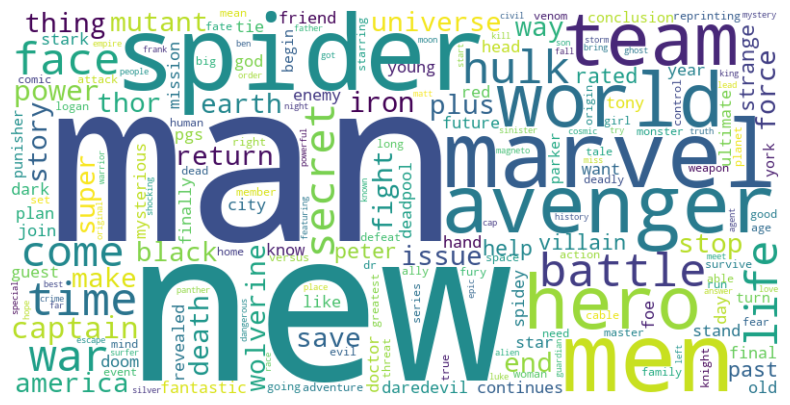


Top words by TF-IDF score:
man: 0.0238
new: 0.0206
spider: 0.0168
men: 0.0143
marvel: 0.0141
avenger: 0.0137
world: 0.0118
hero: 0.0115
team: 0.0114
battle: 0.0111
time: 0.0110
war: 0.0105
hulk: 0.0104
face: 0.0101
life: 0.0101
come: 0.0096
secret: 0.0096
captain: 0.0095
power: 0.0091
iron: 0.0087
mutant: 0.0083
issue: 0.0083
save: 0.0083
america: 0.0083
make: 0.0083
earth: 0.0080
wolverine: 0.0077
black: 0.0077
universe: 0.0076
plus: 0.0076


In [50]:
# New dataframe using only descriptions for wordcloud generation
df_descriptions = df4_copied['issue_description'].copy()

# Initialize vectorizer and fit /transform data
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(df_descriptions)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Calculate TF-IDF average scores for each word
tfidf_scores = vectors.mean(axis=0).A1

# Map words to TF-IDF scores
tfidf_dict = dict(zip(feature_names, tfidf_scores))

# Verify highest_scored words are largest in wordcloud
tfidf_sorted = sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True)

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

# Plot the wordcloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print("")
tfidf_formatted = [f"{word}: {score:.4f}" for word, score in tfidf_sorted]
print("Top words by TF-IDF score:")
for item in tfidf_formatted[:30]:
    print(item)

In [51]:
get_network_graph()